In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
! kaggle datasets download -d safurahajiheidari/kidney-stone-images

 24% 5.00M/21.1M [00:00<00:00, 34.0MB/s]
100% 21.1M/21.1M [00:00<00:00, 107MB/s] 


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/kidney-stone-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

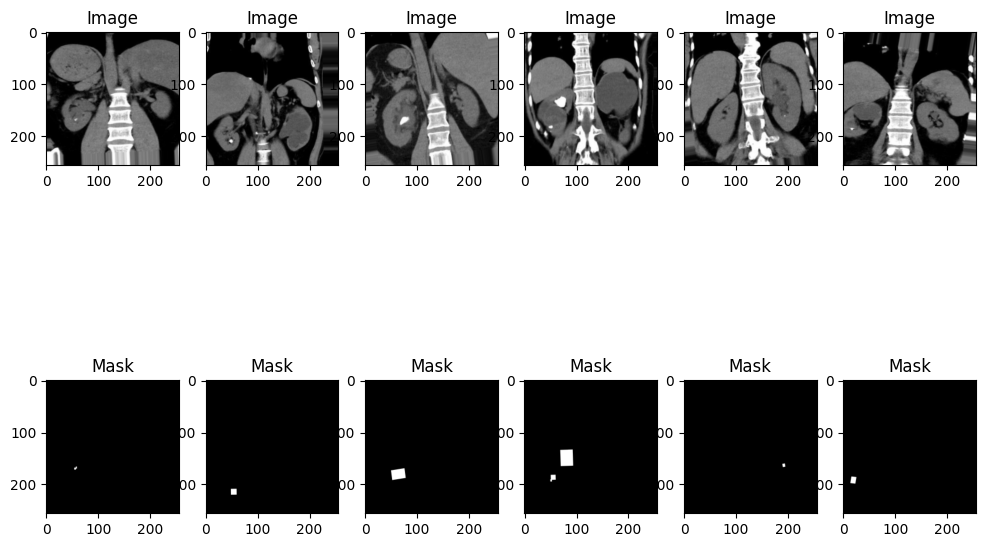

In [ ]:
import matplotlib.pyplot as plt

# Set batch size for visualization
visualization_batch_size = 10

# Function to visualize images and masks
def visualize_images_and_masks(generator):
    images, masks = next(generator)

    num_batches = visualization_batch_size // 6  # Calculate number of rows needed

    for i in range(num_batches):
        plt.figure(figsize=(12, 8))

        for j in range(6):
            index = i * 6 + j
            if index >= visualization_batch_size:
                break

            image = images[index]
            mask = masks[index, :, :, 0]  # Assuming a binary mask; adjust if using multi-class segmentation

            plt.subplot(2, 6, j + 1)
            plt.imshow(image)
            plt.title('Image')

            plt.subplot(2, 6, j + 7)
            plt.imshow(mask, cmap='gray')  # Adjust cmap based on the type of mask
            plt.title('Mask')

        plt.subplots_adjust(wspace=0.2, hspace=0.3)
        plt.show()

# Visualize images and masks
visualization_generator = data_generator('/content/valid', batch_size=visualization_batch_size)
visualize_images_and_masks(visualization_generator)


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_stone_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []
    for line in lines:
        parts = line.strip().split()
        class_label = int(parts[0])
        x, y, width, height = map(float, parts[1:])
        data.append((class_label, x, y, width, height))

    return data

def create_binary_mask(image_size, stone_data):
    mask = np.zeros(image_size, dtype=np.uint8)
    for stone in stone_data:
        x, y, width, height = stone[1:]
        x = int(x * image_size[1])  # Convert normalized coordinates to pixel coordinates
        y = int(y * image_size[0])
        width = int(width * image_size[1])
        height = int(height * image_size[0])

        mask[y:y+height, x:x+width] = 1

    return mask

# Function to create a data generator with variable input sizes and augmentation
def data_generator(folder, batch_size):
    # Define data augmentation parameters
    data_gen_args = dict(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    while True:
        image_list, mask_list = [], []

        # List files in the 'images' directory
        for filename in os.listdir(os.path.join(folder, 'images')):
            if filename.endswith(".jpg"):
                image_path = os.path.join(folder, 'images', filename)

                # Modify the mask file naming convention
                mask_filename = filename.replace(".jpg", ".txt")
                mask_path = os.path.join(folder, 'labels', mask_filename)

                # Read and preprocess images
                image = cv2.imread(image_path)
                image = cv2.resize(image, (256, 256))  # Resize to a fixed size
                image_list.append(image)

                # Read and preprocess masks
                stone_data = load_stone_data(mask_path)
                mask = create_binary_mask(image.shape[:2], stone_data) # image.shape[:2]: This extracts the height and width dimensions of the image.
                mask_list.append(mask)

                if len(image_list) == batch_size:
                    # Apply data augmentation to the images and masks
                    augmented_images = image_datagen.flow(np.array(image_list), batch_size=batch_size, seed=1)
                    augmented_masks = mask_datagen.flow(np.array(mask_list)[:, :, :, np.newaxis], batch_size=batch_size, seed=1)

                    yield next(augmented_images), next(augmented_masks)

                    image_list, mask_list = [], []

# Load image and mask sizes
num_classes = 1

# Define the U-Net model with variable input sizes
def unet_model(input_shape, num_classes):
    # Encoder
    inputs = tf.keras.Input(shape=input_shape)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.Conv2D(256, 2, activation='relu', padding='same')(up5)
    merge5 = layers.concatenate([conv3, up5], axis=3)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = layers.Conv2D(128, 2, activation='relu', padding='same')(up6)
    merge6 = layers.concatenate([conv2, up6], axis=3)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = layers.Conv2D(64, 2, activation='relu', padding='same')(up7)
    merge7 = layers.concatenate([conv1, up7], axis=3)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(conv7) # num_classes: The number of channels in the output. In this case, it's typically set to 1 for binary segmentation (foreground/background) or the number of classes for multi-class segmentation.

    model = models.Model(inputs=inputs, outputs=outputs) # the model is a Keras model that takes an input image tensor (inputs) and produces an output tensor (outputs) representing the segmentation mask.
    return model

# Create the U-Net model
model = unet_model((256, 256, 3), num_classes)

# Compile the model with binary crossentropy loss and an optimizer (e.g., Adam)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Rest of the code remains unchanged (generator creation, training, and evaluation)

# Set batch size and create generators for training and validation
batch_size = 32
train_generator = data_generator('/content/train', batch_size)
valid_generator = data_generator('/content/valid', batch_size)

# Calculate the number of steps per epoch for training and validation
train_steps_per_epoch = len(os.listdir('/content/train/images')) // batch_size
valid_steps_per_epoch = len(os.listdir('/content/valid/images')) // batch_size

# Train the model using generators
model.fit(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=10, validation_data=valid_generator, validation_steps=valid_steps_per_epoch)

# Evaluate the model on the test set
test_images, test_masks = next(data_generator('/content/test', len(os.listdir('/content/test/images'))))
test_loss, test_accuracy = model.evaluate(test_images, test_masks)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


Epoch 1/10
32/32 [==============================] - 65s 2s/step - loss: 0.0479 - accuracy: 0.9718 - val_loss: 4.0136e-04 - val_accuracy: 0.9952
Epoch 2/10
32/32 [==============================] - 61s 2s/step - loss: 3.2796e-04 - accuracy: 0.9943 - val_loss: 2.4323e-04 - val_accuracy: 0.9952
Epoch 3/10
32/32 [==============================] - 59s 2s/step - loss: 2.6189e-04 - accuracy: 0.9943 - val_loss: 2.0980e-04 - val_accuracy: 0.9952
Epoch 4/10
32/32 [==============================] - 60s 2s/step - loss: 2.4855e-04 - accuracy: 0.9943 - val_loss: 2.0579e-04 - val_accuracy: 0.9952
Epoch 5/10
32/32 [==============================] - 61s 2s/step - loss: 2.4337e-04 - accuracy: 0.9943 - val_loss: 2.0103e-04 - val_accuracy: 0.9952
Epoch 6/10
32/32 [==============================] - 61s 2s/step - loss: 2.3998e-04 - accuracy: 0.9943 - val_loss: 1.9925e-04 - val_accuracy: 0.9952
Epoch 7/10
32/32 [==============================] - 60s 2s/step - loss: 2.3794e-04 - accuracy: 0.9943 - val_loss: 1.

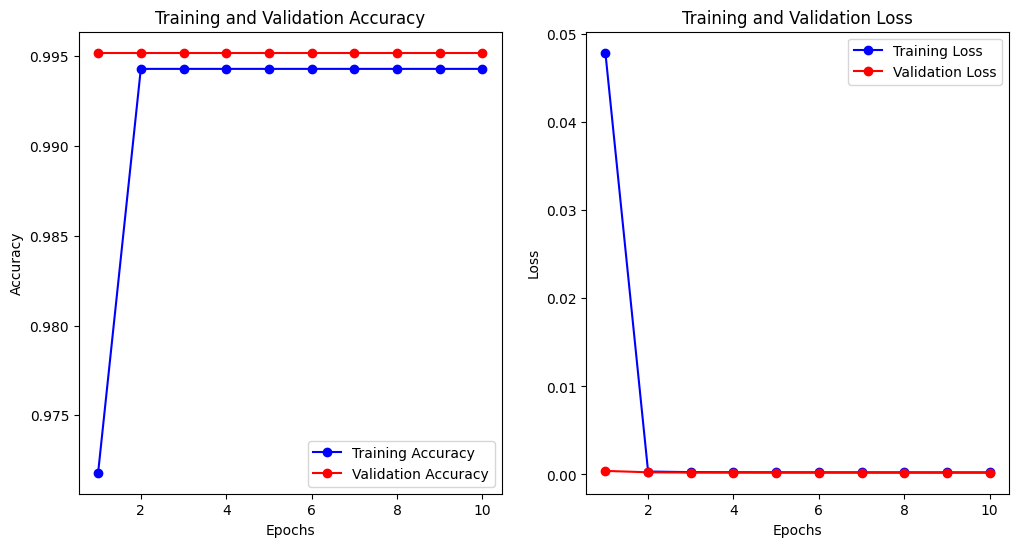

In [ ]:
import matplotlib.pyplot as plt

# Example data
epochs = range(1, 11)  # Assuming 10 epochs
train_loss = [0.0479, 3.2796e-04, 2.6189e-04, 2.4855e-04, 2.4337e-04, 2.3998e-04, 2.3794e-04, 2.3579e-04, 2.3430e-04, 2.3184e-04]
train_accuracy = [0.9718, 0.9943, 0.9943, 0.9943, 0.9943, 0.9943, 0.9943, 0.9943, 0.9943, 0.9943]
val_loss = [4.0136e-04, 2.4323e-04, 2.0980e-04, 2.0579e-04, 2.0103e-04, 1.9925e-04, 1.9814e-04, 1.9564e-04, 1.9521e-04, 1.9392e-04]
val_accuracy = [0.9952, 0.9952, 0.9952, 0.9952, 0.9952, 0.9952, 0.9952, 0.9952, 0.9952, 0.9952]

# Plotting accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Assuming 'model' is your U-Net model
model.save('/content/drive/MyDrive/Colab Notebooks/saved_weights/unet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/saved_weights/unet_model.h5')


In [ ]:
# Saving the model
# Assuming 'model' is your U-Net model
model.save_weights('/content/drive/MyDrive/Colab Notebooks/saved_weights/Kidney_Stone_Weights/unet_weights.h5')

In [ ]:
# Assuming 'model' is your U-Net model
model.save_weights('unet_weights.h5')

1/1 [==============================] - 0s 31ms/step
In this image 0 stones have been detected.


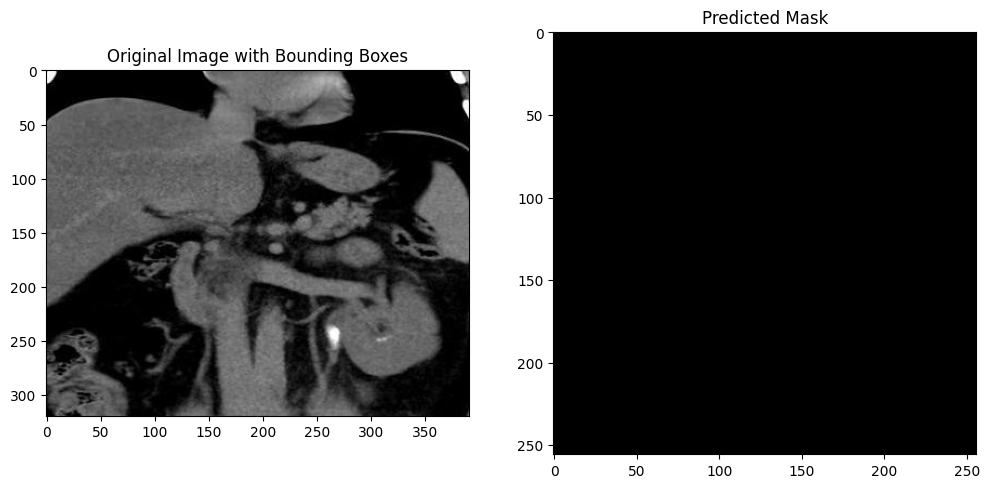

1/1 [==============================] - 0s 34ms/step
In this image 0 stones have been detected.


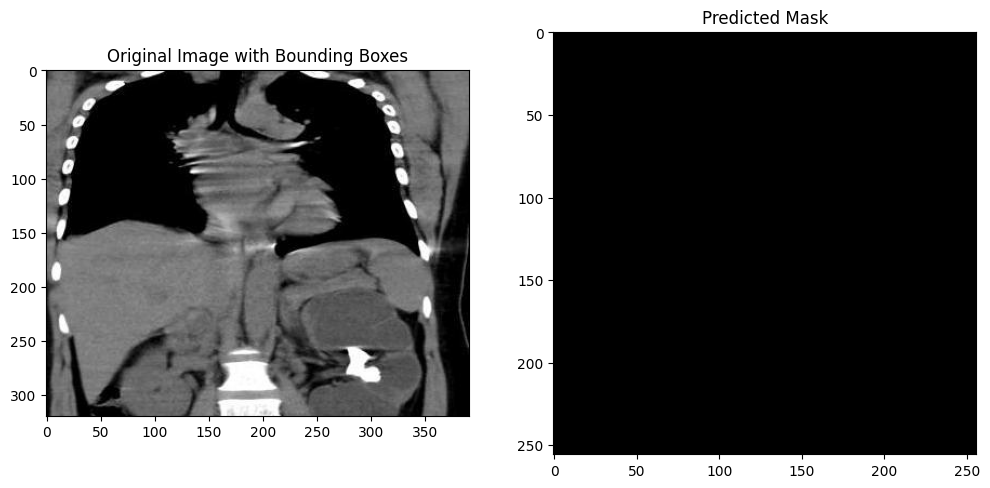

1/1 [==============================] - 0s 31ms/step
In this image 0 stones have been detected.


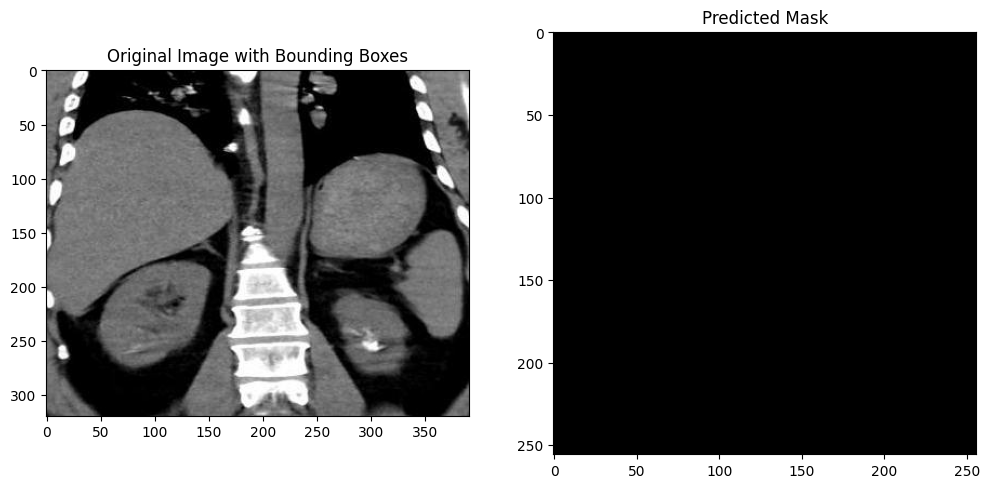

1/1 [==============================] - 0s 56ms/step
In this image 1 stones have been detected.
Stone 1 is: Tas_Var
Coordinates are: [255, 255, 256, 256]
Confidence is: 0.02


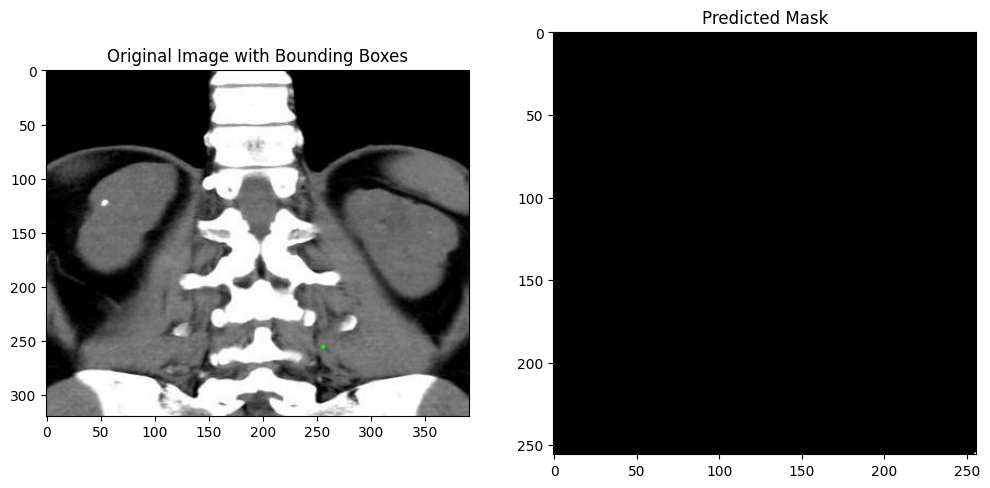

1/1 [==============================] - 0s 31ms/step
In this image 0 stones have been detected.


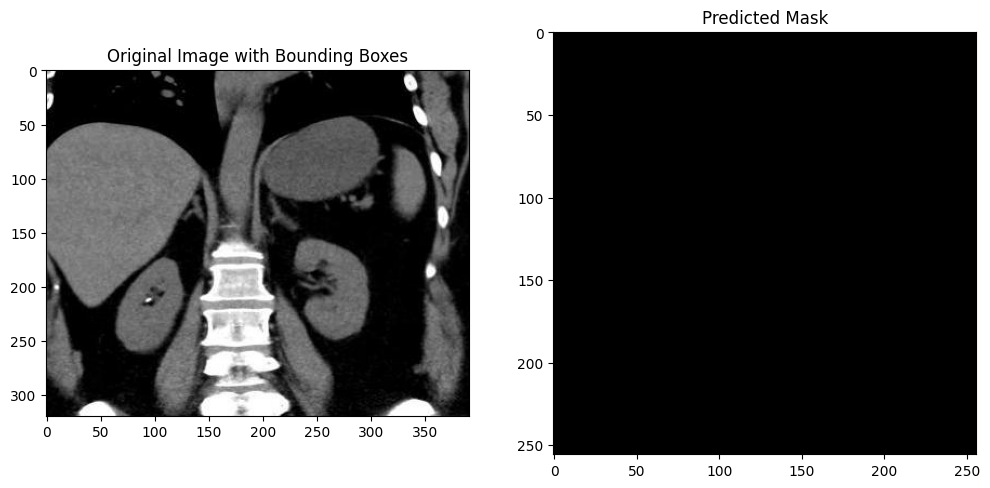

In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to perform inference on an image and analyze detected stones
def infer_and_analyze(model, image_path, threshold=0.01):
    # Read and preprocess the image
    image = cv2.imread(image_path)
    original_image = image.copy()  # Save a copy for visualization
    image = cv2.resize(image, (256, 256))  # Resize to match the model's input size
    image = image / 255.0  # Normalize to [0, 1]

    # Perform inference
    prediction = loaded_model.predict(np.expand_dims(image, axis=0))

    # Threshold the prediction to get a binary mask
    mask = (prediction[0, :, :, 0] > threshold).astype(np.uint8)

    # Analyze the detected stones
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_stones = len(contours)

    print(f"In this image {num_stones} stones have been detected.")

    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        confidence = np.max(prediction[0, y:y+h, x:x+w, 0])

        print(f"Stone {i + 1} is: Tas_Var")
        print(f"Coordinates are: [{x}, {y}, {x + w}, {y + h}]")
        print(f"Confidence is: {confidence:.2f}")

        # Only print "-------" if confidence is below the threshold
        if confidence < threshold:
            print("-------")

        # Draw the bounding box on the original image
        cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Visualize the original image and the predicted mask
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image with Bounding Boxes')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

# Load the trained U-Net model
# model = unet_model((256, 256, 3), num_classes)
# model.load_weights('/content/drive/MyDrive/Colab Notebooks/saved_weights/Kidney_Stone_Weights/unet_weights.h5')  # Replace with the actual path to your trained weights
#model=loaded_model
# Directory containing test images
test_images_dir = '/content/test/images'

# List all image filenames in the test folder
all_image_filenames = [filename for filename in os.listdir(test_images_dir) if filename.endswith('.jpg')]

# Randomly select 5 image filenames
sample_image_filenames = random.sample(all_image_filenames, 5)

# Iterate over sample images and perform inference
for image_filename in sample_image_filenames:
    image_path = os.path.join(test_images_dir, image_filename)
    infer_and_analyze(loaded_model, image_path)


## YOLO

In [ ]:
!pip install ultralytics

In [ ]:
import ultralytics
from ultralytics import YOLO
model = YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:00<00:00, 302MB/s]


In [ ]:
first_model = model.train(data='/content/data.yaml',seed=42,epochs=5)

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=Fal

100%|██████████| 755k/755k [00:00<00:00, 23.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 105MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 1054 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1054/1054 [00:00<00:00, 2060.80it/s]

train: New cache created: /content/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid/labels... 123 images, 0 backgrounds, 0 corrupt: 100%|██████████| 123/123 [00:00<00:00, 933.75it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.79G      2.332      2.569      1.386         41        640: 100%|██████████| 66/66 [00:38<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        123        325      0.622      0.508      0.493      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.11G      2.176      1.261      1.334         39        640: 100%|██████████| 66/66 [00:33<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        123        325       0.48      0.366      0.314       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.09G      2.182      1.287      1.331         47        640: 100%|██████████| 66/66 [00:34<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        123        325      0.638      0.548      0.504      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.13G      2.107      1.154      1.284         33        640: 100%|██████████| 66/66 [00:35<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

                   all        123        325      0.702       0.61      0.607      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5       7.1G      2.058      1.106      1.288         49        640: 100%|██████████| 66/66 [00:34<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        123        325      0.679      0.572      0.588      0.217



5 epochs completed in 0.058 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


                   all        123        325      0.706      0.606      0.607      0.248
Speed: 0.4ms preprocess, 9.6ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train


In [ ]:
model.train(data='/content/data.yaml',seed=42,epochs=5,optimizer='Adam')

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=Fa

train: Scanning /content/train/labels.cache... 1054 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1054/1054 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 123 images, 0 backgrounds, 0 corrupt: 100%|██████████| 123/123 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.87G        2.3      1.444       1.37         41        640: 100%|██████████| 66/66 [00:38<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all        123        325          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.08G      2.327       1.48      1.405         39        640: 100%|██████████| 66/66 [00:35<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all        123        325       0.22       0.44      0.216     0.0676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.09G      2.298      1.435      1.381         47        640: 100%|██████████| 66/66 [00:35<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        123        325      0.469      0.437      0.373      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.12G      2.224      1.308      1.328         33        640: 100%|██████████| 66/66 [00:35<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        123        325      0.662      0.585      0.552      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5       7.1G      2.125      1.246      1.331         49        640: 100%|██████████| 66/66 [00:35<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        123        325       0.54      0.509      0.515       0.19



5 epochs completed in 0.057 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 52.0MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


                   all        123        325      0.662      0.585      0.552      0.203
Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ab898a4a620>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from glob import glob
import random
import cv2
import warnings
warnings.simplefilter('ignore')

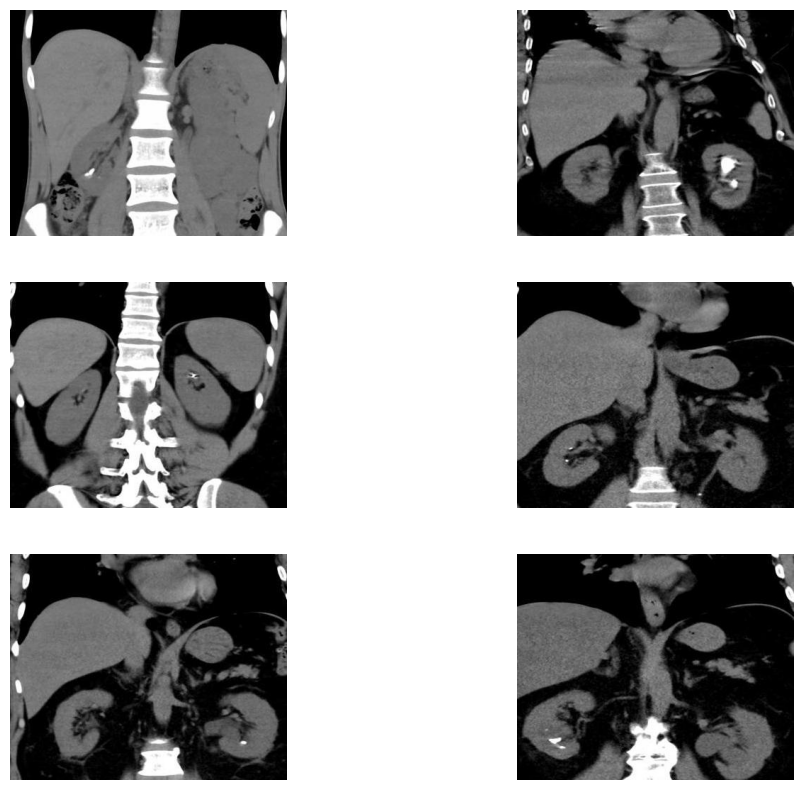

In [ ]:
root_path = '/content/test/images/*'
num_samples = 6
images_data = glob(root_path)
random_image = random.sample(images_data, num_samples)

plt.figure(figsize=(12,10))
for i in range(num_samples):
    plt.subplot(3,2,i+1)
    plt.imshow(cv2.imread(random_image[i]))
    plt.axis('off')

In [ ]:
images = []
for i in range(num_samples):
    yolo_outputs = model.predict(random_image[i])
    output = yolo_outputs[0]
    box = output.boxes
    names = output.names
    print('**********************')
    for j in range(len(box)):
        labels = names[box.cls[j].item()]
        coordinates = box.xyxy[j].tolist()
        confidence = np.round(box.conf[j].item(), 2)
        print(f'In this image {len(box)} stones has been detected.')
        print(f'Stone {j + 1} is: {labels}')
        print(f'Coordinates are: {coordinates}')
        print(f'Confidence is: {confidence}')
        print('-------')

    # Store the image in the 'images' list
    images.append(output.plot()[:, :, ::-1])


image 1/1 /content/test/images/1-3-46-670589-33-1-63703718086120120200001-5487554579919763006_png_jpg.rf.9fd67251e99a47dbe83a5db6efe6c016.jpg: 544x640 4 Tas_Vars, 35.7ms
Speed: 3.3ms preprocess, 35.7ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)
**********************
In this image 4 stones has been detected.
Stone 1 is: Tas_Var
Coordinates are: [112.77848052978516, 223.08103942871094, 122.3058090209961, 231.3553924560547]
Confidence is: 0.52
-------
In this image 4 stones has been detected.
Stone 2 is: Tas_Var
Coordinates are: [110.4261474609375, 222.431884765625, 121.43775177001953, 234.61155700683594]
Confidence is: 0.45
-------
In this image 4 stones has been detected.
Stone 3 is: Tas_Var
Coordinates are: [160.4106903076172, 145.1497039794922, 167.1681365966797, 150.5654754638672]
Confidence is: 0.34
-------
In this image 4 stones has been detected.
Stone 4 is: Tas_Var
Coordinates are: [105.28417205810547, 224.3553466796875, 121.44617462158203, 236.81654357910

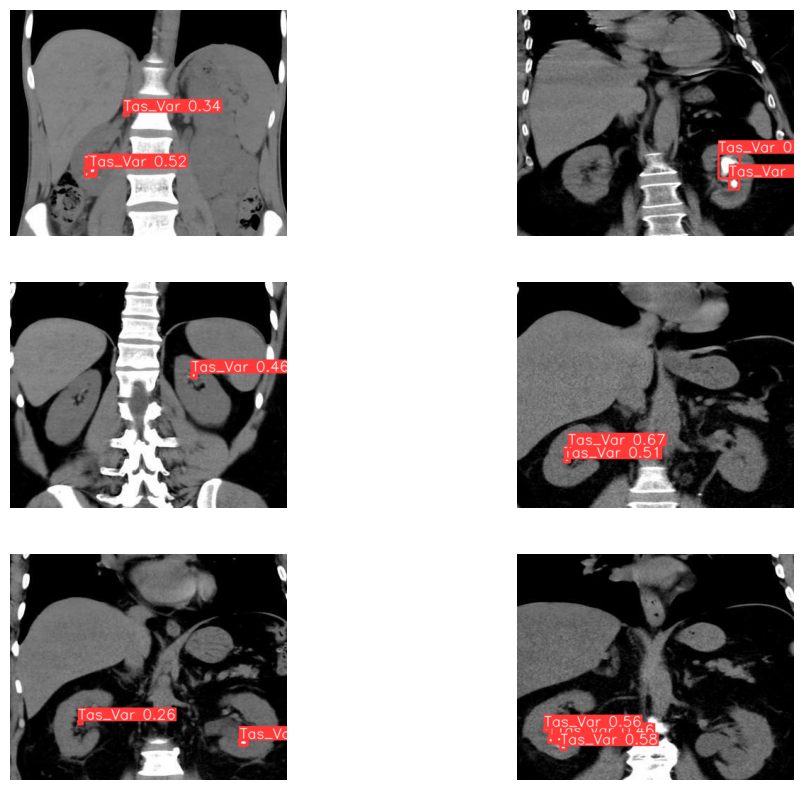

In [ ]:
plt.figure(figsize=(12,10))
for i, img in enumerate(images):
    plt.subplot(3, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')